<a href="https://colab.research.google.com/github/RansadiDeAlwis/unet---segmentation/blob/main/Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 21.33 MiB/s, done.
Resolving deltas: 100% (3/3), done.


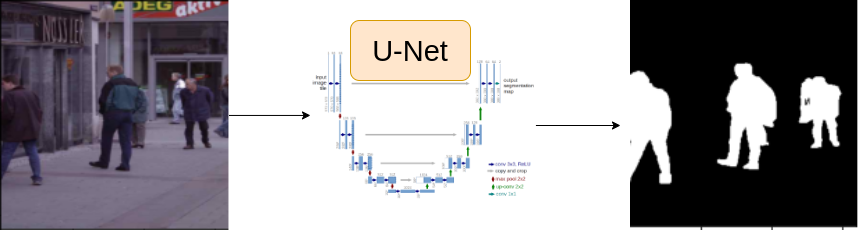

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
csv_file = "/content/Human-Segmentation-Dataset-master/train.csv"
data_dir = "/content/"

DEVICE = "cuda"

NUM_EPOCHS = 25
LEARNING_RATE = 0.003
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = "timm-efficientnet-b0"
WEIGHTS = "imagenet"


In [ ]:
df = pd.read_csv(csv_file)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[2]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

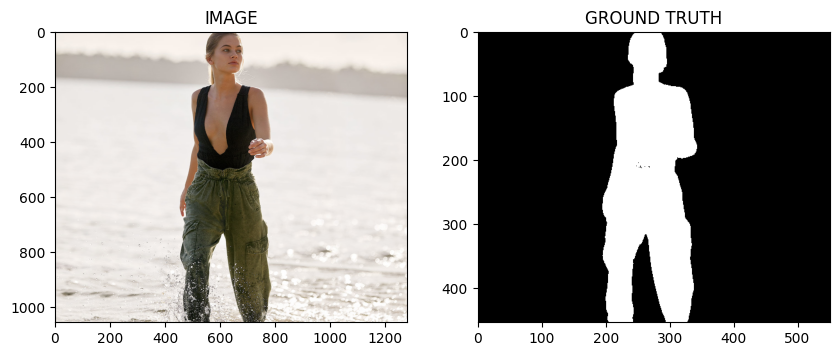

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df ,valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_aug():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_aug():
  return A.Compose([
      A.Resize(IMAGE_SIZE, IMAGE_SIZE),

  ])



# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df = df
    self.augmentations = augmentations


  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]
    image_path = row.images
    mask_path = row.masks

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image.shape[:2] != mask.shape[:2]:
        mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

    mask = np.expand_dims(mask, axis = -1)

    if self.augmentations:
      aug = self.augmentations(image = image, mask = mask)
      image = aug["image"]
      mask = aug["mask"]

    image = np.transpose(image, (2,0,1)).astype(np.float32)
    mask = np.transpose(mask, (2,0,1)).astype(np.float32)


    image = torch.Tensor(image) / 255.0
    mask = torch.round(torch.Tensor(mask) / 255.0)

    return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_aug())
validset = SegmentationDataset(valid_df, get_valid_aug())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


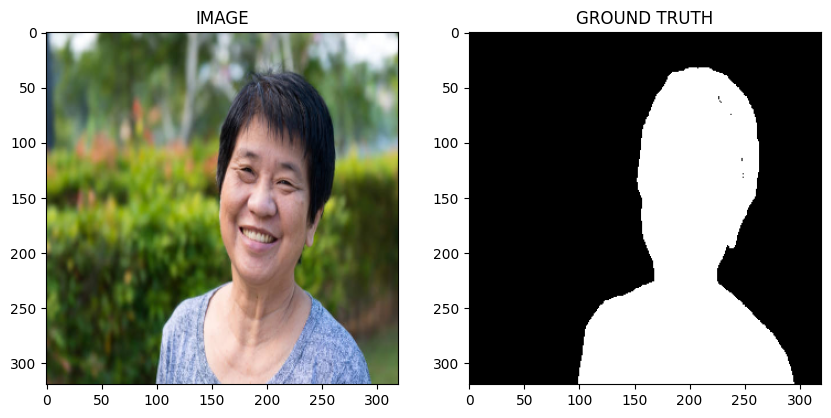

In [ ]:
idx = 3
image, mask   = trainset[idx]

helper.show_image(image,mask)


# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
train_loader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
valid_loader = DataLoader(validset, batch_size = BATCH_SIZE)

In [ ]:
print(f"total number of batches in train_loader : {len(train_loader)}")
print(f"total number of batches in valid_loader : {len(valid_loader)}")

total number of batches in train_loader : 15
total number of batches in valid_loader : 4


In [ ]:
for image, mask in train_loader:
  break
print(f"Shape of image : {image.shape}")
print(f"Shape of mask : {mask.shape}")

Shape of image : torch.Size([16, 3, 320, 320])
Shape of mask : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
  def __init__(self):
    super(SegmentationModel, self).__init__()

    self.arc = smp.Unet(
        encoder_name = ENCODER,
        encoder_weights = WEIGHTS,
        in_channels = 3,
        classes = 1,
        activation = None
    )

  def forward(self, images, masks = None):

    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode = 'binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2
    return logits


In [ ]:
model = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 136MB/s] 


SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoi

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader, model, optimizer):
  model.train()
  total_loss = 0

  for images, masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [ ]:
def valid_fn(data_loader, model, optimizer):
  model.eval()
  total_loss = 0

  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      optimizer.zero_grad()
      logits, loss = model(images, masks)

      optimizer.step()

      total_loss += loss.item()

  return total_loss / len(data_loader)



# Task 8 : Train Model

In [ ]:
optimizer  = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [ ]:
best_valid_loss = np.inf
for epoch in range(NUM_EPOCHS):
  train_loss = train_fn(train_loader, model, optimizer)
  valid_loss = valid_fn(valid_loader, model, optimizer)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), "best_model.pt")
    print("Saved Best Model!")
    best_valid_loss = valid_loss

  print(f"Epoch : {epoch+1}")
  print(f"Train Loss : {train_loss:.4f}")
  print(f"Valid Loss : {valid_loss:.4f}")



100%|██████████| 4/4 [00:00<00:00,  5.91it/s]


Saved Best Model!
Epoch : 1
Train Loss : 0.0758
Valid Loss : 0.1687


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 2
Train Loss : 0.0852
Valid Loss : 0.1886


100%|██████████| 4/4 [00:00<00:00,  5.98it/s]


Epoch : 3
Train Loss : 0.0827
Valid Loss : 0.2032


100%|██████████| 4/4 [00:00<00:00,  5.96it/s]


Epoch : 4
Train Loss : 0.0714
Valid Loss : 0.1719


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 5
Train Loss : 0.0699
Valid Loss : 0.1833


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch : 6
Train Loss : 0.0677
Valid Loss : 0.1856


100%|██████████| 4/4 [00:00<00:00,  4.59it/s]


Epoch : 7
Train Loss : 0.0658
Valid Loss : 0.1755


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Saved Best Model!
Epoch : 8
Train Loss : 0.0642
Valid Loss : 0.1667


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


Epoch : 9
Train Loss : 0.0644
Valid Loss : 0.1860


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch : 10
Train Loss : 0.0689
Valid Loss : 0.2354


100%|██████████| 4/4 [00:00<00:00,  6.20it/s]


Epoch : 11
Train Loss : 0.0756
Valid Loss : 0.2052


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


Epoch : 12
Train Loss : 0.0735
Valid Loss : 0.2174


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Saved Best Model!
Epoch : 13
Train Loss : 0.0824
Valid Loss : 0.1462


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Epoch : 14
Train Loss : 0.0814
Valid Loss : 0.2244


100%|██████████| 4/4 [00:00<00:00,  5.86it/s]


Epoch : 15
Train Loss : 0.0820
Valid Loss : 0.1848


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch : 16
Train Loss : 0.0798
Valid Loss : 0.1829


100%|██████████| 4/4 [00:00<00:00,  5.87it/s]


Epoch : 17
Train Loss : 0.0662
Valid Loss : 0.1713


100%|██████████| 4/4 [00:00<00:00,  5.99it/s]


Epoch : 18
Train Loss : 0.0744
Valid Loss : 0.1827


100%|██████████| 4/4 [00:00<00:00,  5.83it/s]


Epoch : 19
Train Loss : 0.0848
Valid Loss : 0.2212


100%|██████████| 4/4 [00:00<00:00,  5.93it/s]


Epoch : 20
Train Loss : 0.0969
Valid Loss : 0.2630


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Epoch : 21
Train Loss : 0.0818
Valid Loss : 0.1964


100%|██████████| 4/4 [00:00<00:00,  6.04it/s]


Epoch : 22
Train Loss : 0.0710
Valid Loss : 0.1725


100%|██████████| 4/4 [00:00<00:00,  5.85it/s]


Epoch : 23
Train Loss : 0.0789
Valid Loss : 0.2641


100%|██████████| 4/4 [00:00<00:00,  6.02it/s]


Epoch : 24
Train Loss : 0.0772
Valid Loss : 0.1770


100%|██████████| 4/4 [00:00<00:00,  6.03it/s]

Epoch : 25
Train Loss : 0.1293
Valid Loss : 0.2478


# Task 9 : Inference

In [41]:
idx = 20

model.load_state_dict(torch.load("/content/best_model.pt"))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask>0.5)*1.0

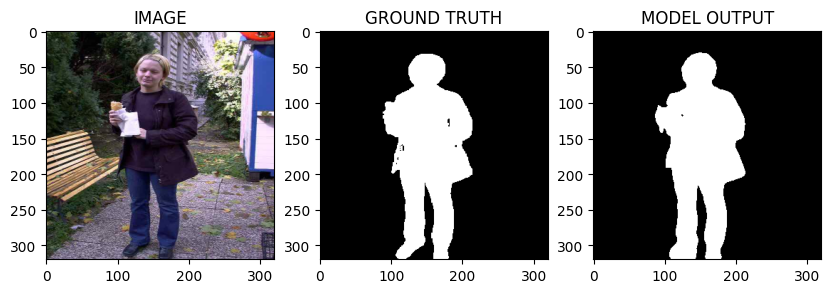

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))